In [100]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, avg, col, format_number
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, SparkSession, Row

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import time


url = "https://stats.nba.com/stats/leagueleaders"
params = {
    "LeagueID": "00",
    "PerMode": "Totals",
    "Scope": "RS",
    "Season": "2023-24",
    "SeasonType": "Regular Season",
    "StatCategory": "PTS"
}

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

response = requests.get(url, params=params, headers=headers)
data = response.json()

# Print out the player stats
for player in data['resultSet']['rowSet']:
    print(player)


[1629029, 1, 'Luka Doncic', 1610612742, 'DAL', 70, 2624, 804, 1652, 0.487, 284, 744, 0.382, 478, 608, 0.786, 59, 588, 647, 686, 99, 38, 282, 149, 2370, 2580, 2.43, 0.35]
[1628983, 2, 'Shai Gilgeous-Alexander', 1610612760, 'OKC', 75, 2553, 796, 1487, 0.535, 95, 269, 0.353, 567, 649, 0.874, 65, 350, 415, 465, 150, 67, 162, 184, 2254, 2416, 2.87, 0.93]
[203507, 3, 'Giannis Antetokounmpo', 1610612749, 'MIL', 73, 2567, 837, 1369, 0.611, 34, 124, 0.274, 514, 782, 0.657, 196, 645, 841, 476, 87, 79, 250, 210, 2222, 2655, 1.9, 0.35]
[1628973, 4, 'Jalen Brunson', 1610612752, 'NYK', 77, 2726, 790, 1648, 0.479, 211, 526, 0.401, 421, 497, 0.847, 43, 235, 278, 519, 70, 13, 186, 144, 2212, 1972, 2.79, 0.38]
[203999, 5, 'Nikola Jokic', 1610612743, 'DEN', 79, 2737, 822, 1411, 0.583, 83, 231, 0.359, 358, 438, 0.817, 223, 753, 976, 708, 108, 68, 237, 194, 2085, 3039, 2.99, 0.46]
[1630162, 6, 'Anthony Edwards', 1610612750, 'MIN', 79, 2770, 718, 1558, 0.461, 190, 532, 0.357, 423, 506, 0.836, 52, 378, 430, 

In [101]:
def fetch_nba_data(season, PerMode="Totals"):
    url = "https://stats.nba.com/stats/leagueleaders"
    params = {
        "LeagueID": "00",
        "PerMode": PerMode,
        "Scope": "RS",
        "Season": season,
        "SeasonType": "Regular Season",
        "StatCategory": "PTS",
    }

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }

    response = requests.get(url, params=params, headers=headers)
    time.sleep(1)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        return None

In [98]:
data_header = "LeagueID,PerMode,StatCategory,Season,SeasonType,Scope,ActiveFlag,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV"

In [90]:
seasons =  [f"{year}-{str(year + 1)[2:]}" for year in range(1980, 2024)]

In [119]:
def create_schema(seasons, permode="Totals"):
    data_header = "LeagueID,PerMode,StatCategory,Season,SeasonType,Scope,ActiveFlag,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV"
    failed_seasons = []
    with open(f"NBA_players_{permode}.csv", "w") as f:
        f.write(data_header + "\n")
        for i in seasons:
            data = fetch_nba_data(i, PerMode=permode)
            params
            if data:
                for player in data["resultSet"]["rowSet"]:
                    row = list(data["parameters"].values()) + player
                    f.write(",".join([str(x) for x in row]) + "\n")
            else:
                print(f"Failed to fetch data for season {i}")

In [120]:
create_schema(seasons, permode="Totals")

In [121]:
create_schema(seasons, permode="Per48")

* **PLAYER_ID**: Unikalny identyfikator gracza.
* **RANK**: Pozycja gracza w rankingu, zazwyczaj na podstawie punktów, efektywności lub innego wskaźnika.
* **PLAYER**: Imię i nazwisko gracza.
* **TEAM_ID**: Unikalny identyfikator drużyny.
* **TEAM**: Nazwa drużyny, w której gra zawodnik.
* **GP** (Games Played): Liczba rozegranych meczów.
* **MIN** (Minutes): Średnia liczba minut spędzonych na boisku na mecz.
* **FGM** (Field Goals Made): Średnia liczba celnych rzutów z gry na mecz.
* **FGA** (Field Goals Attempted): Średnia liczba prób rzutów z gry na mecz.
* **FG_PCT** (Field Goal Percentage): Procent celności rzutów z gry.
* **FG3M** (Three-Point Field Goals Made): Średnia liczba celnych rzutów za trzy punkty na mecz.
* **FG3A** (Three-Point Field Goals Attempted): Średnia liczba prób rzutów za trzy punkty na mecz.
* **FG3_PCT** (Three-Point Field Goal Percentage): Procent celności rzutów za trzy punkty.
* **FTM** (Free Throws Made): Średnia liczba celnych rzutów wolnych na mecz.
* **FTA** (Free Throws Attempted): Średnia liczba prób rzutów wolnych na mecz.
* **FT_PCT** (Free Throw Percentage): Procent celności rzutów wolnych.
* **OREB** (Offensive Rebounds): Średnia liczba zbiórek w ataku na mecz.
* **DREB** (Defensive Rebounds): Średnia liczba zbiórek w obronie na mecz.
* **REB** (Rebounds): Średnia liczba zbiórek na mecz (łącznie ofensywne i defensywne).
* **AST** (Assists): Średnia liczba asyst na mecz.
* **STL** (Steals): Średnia liczba przechwytów na mecz.
* **BLK** (Blocks): Średnia liczba bloków na mecz.
* **TOV** (Turnovers): Średnia liczba strat na mecz.
* **PF** (Personal Fouls): Średnia liczba fauli osobistych na mecz.
* **PTS** (Points): Średnia liczba punktów zdobytych na mecz.
EFF (Efficiency): Wskaźnik efektywności gracza. Często obliczany jako suma pozytywnych statystyk (punkty, zbiórki, asysty, przechwyty, bloki) minus suma * **negatywnych** statystyk (straty, chybione rzuty, chybione rzuty wolne).
* **AST_TOV** (Assist to Turnover Ratio): Stosunek asyst do strat.
* **STL_TOV** (Steal to Turnover Ratio): Stosunek przechwytów do strat.


In [124]:
spark = SparkSession.builder \
    .appName("Best Scorers") \
    .getOrCreate()

In [125]:
df = spark.read.csv('NBA_players_Totals.csv', header=True, inferSchema=True)

In [126]:
df.show()

+--------+-------+------------+-------+--------------+-----+----------+---------+----+-------------------+----------+----+---+----+---+----+------+----+----+-------+---+---+------+----+----+----+---+---+---+---+---+----+----+-------+-------+
|LeagueID|PerMode|StatCategory| Season|    SeasonType|Scope|ActiveFlag|PLAYER_ID|RANK|             PLAYER|   TEAM_ID|TEAM| GP| MIN|FGM| FGA|FG_PCT|FG3M|FG3A|FG3_PCT|FTM|FTA|FT_PCT|OREB|DREB| REB|AST|STL|BLK|TOV| PF| PTS| EFF|AST_TOV|STL_TOV|
+--------+-------+------------+-------+--------------+-----+----------+---------+----+-------------------+----------+----+---+----+---+----+------+----+----+-------+---+---+------+----+----+----+---+---+---+---+---+----+----+-------+-------+
|       0| Totals|         PTS|1980-81|Regular Season|   RS|      None|    76504|   1|     Adrian Dantley|1610612762| UTH| 80|3417|909|1627| 0.559|   2|   7|  0.286|632|784| 0.806| 192| 317| 509|322|109| 18|282|245|2452|2258|   1.14|   0.39|
|       0| Totals|         PTS|1

In [138]:
aggregated_df = df.groupBy('PLAYER', 'PLAYER_ID') \
    .agg(
        sum('GP').alias('Total_GP'),
        avg('MIN').alias('Avg_MIN'),
        sum('PTS').alias('Total_PTS'),
        sum('AST').alias('Total_AST'),
        sum('REB').alias('Total_REB'),
        sum('STL').alias('Total_STL'),
        sum('BLK').alias('Total_BLK'),
        avg('EFF').alias('Avg_EFF')
    )

In [139]:
sorted_scorers = aggregated_df.orderBy('Total_PTS', ascending=False)
sorted_scorers.show()

+-----------------+---------+--------+------------------+---------+---------+---------+---------+---------+------------------+
|           PLAYER|PLAYER_ID|Total_GP|           Avg_MIN|Total_PTS|Total_AST|Total_REB|Total_STL|Total_BLK|           Avg_EFF|
+-----------------+---------+--------+------------------+---------+---------+---------+---------+---------+------------------+
|     LeBron James|     2544|    1492|2695.0476190476193|    40474|    11009|    11185|     2275|     1111|2064.4285714285716|
|      Karl Malone|      252|    1476|2886.9473684210525|    36928|     5248|    14968|     2085|     1145|            2093.0|
|      Kobe Bryant|      977|    1346|           2432.15|    33643|     6306|     7047|     1944|      640|            1472.8|
|   Michael Jordan|      893|    1072|            2734.0|    32292|     5633|     6672|     2514|      893|            2086.0|
|    Dirk Nowitzki|     1717|    1522|2446.0476190476193|    31560|     3651|    11489|     1210|     1281|1577

# AVG 3 pints

In [140]:
spark = SparkSession.builder \
    .appName("3-Point Attempts Analysis") \
    .getOrCreate()

24/06/20 19:59:06 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [143]:
df = spark.read.csv('NBA_players_Per48.csv', header=True, inferSchema=True)
df.show()

+--------+-------+------------+-------+--------------+-----+----------+---------+----+-------------------+----------+----+---+----+----+----+------+----+----+-------+----+----+------+----+----+----+---+----+----+----+----+----+----+-------+-------+
|LeagueID|PerMode|StatCategory| Season|    SeasonType|Scope|ActiveFlag|PLAYER_ID|RANK|             PLAYER|   TEAM_ID|TEAM| GP| MIN| FGM| FGA|FG_PCT|FG3M|FG3A|FG3_PCT| FTM| FTA|FT_PCT|OREB|DREB| REB|AST| STL| BLK| TOV|  PF| PTS| EFF|AST_TOV|STL_TOV|
+--------+-------+------------+-------+--------------+-----+----------+---------+----+-------------------+----------+----+---+----+----+----+------+----+----+-------+----+----+------+----+----+----+---+----+----+----+----+----+----+-------+-------+
|       0|  Per48|         PTS|1980-81|Regular Season|   RS|      None|    76804|   1|      George Gervin|1610612759| SAN| 82|2765|14.8|30.0| 0.492| 0.2| 0.6|  0.257| 8.9|10.8| 0.826| 2.2| 5.1| 7.3|4.5|1.63|0.97|4.36|3.68|38.6|31.5|   NULL|   NULL|
|   

In [152]:
season_df = df.groupBy('Season') \
    .agg(
        sum('FG3A').alias('Total_FG3A'),
        avg('FG3A').alias('Avg_FG3A'),
        sum('MIN').alias('Total_MIN')
    )

In [153]:
season_df = season_df.orderBy('Avg_FG3A', ascending=False)
season_df.show()

+-------+-----------------+------------------+---------+
| Season|       Total_FG3A|          Avg_FG3A|Total_MIN|
+-------+-----------------+------------------+---------+
|2021-22|            733.1| 8.145555555555555|   208451|
|2023-24|806.0999999999999| 7.750961538461538|   244705|
|2019-20|            795.3| 7.363888888888888|   217369|
|2022-23|            773.1| 7.362857142857143|   244442|
|2020-21|681.9000000000002| 7.254255319148938|   192058|
|2018-19|731.2000000000002| 7.099029126213594|   243682|
|2017-18|654.3999999999999| 6.479207920792078|   239987|
|2016-17|619.7000000000002| 5.685321100917433|   260537|
|2015-16|595.9999999999999| 5.094017094017093|   279291|
|2013-14|559.6000000000003| 4.549593495934961|   300953|
|2014-15|            479.8|  4.48411214953271|   252851|
|2012-13|763.0000000000002|3.8535353535353547|   416174|
|2008-09|748.4000000000002| 3.704950495049506|   438107|
|2010-11|726.0000000000003| 3.594059405940596|   430735|
|2009-10|718.7000000000002|3.57

In [154]:
player_df = df.groupBy('PLAYER', 'PLAYER_ID').agg(
        sum('FG3A').alias('Total_FG3A'),
        avg('FG3A').alias('Avg_FG3A'),
        sum('MIN').alias('Total_MIN')
    )

In [155]:
player_df.orderBy('Avg_FG3A', ascending=False).show()

+-----------------+---------+------------------+------------------+---------+
|           PLAYER|PLAYER_ID|        Total_FG3A|          Avg_FG3A|Total_MIN|
+-----------------+---------+------------------+------------------+---------+
|  Duncan Robinson|  1629130|41.099999999999994|13.699999999999998|     6471|
|    Malik Beasley|  1627736|              26.2|              13.1|     4430|
|    Stephen Curry|   201939|             143.4|13.036363636363637|    28282|
|      Buddy Hield|  1627741| 90.19999999999999|12.885714285714284|    16429|
|  Devonte' Graham|  1628984|              25.2|              12.6|     4373|
|  Anfernee Simons|  1629014|              12.4|              12.4|     2171|
|     Jordan Poole|  1629673|              36.1|12.033333333333333|     7087|
|      Luka Doncic|  1629029|              71.3|11.883333333333333|    13943|
| Tim Hardaway Jr.|   203501|              70.8|11.799999999999999|    12559|
| Donte DiVincenzo|  1628978|              23.5|             11.

# Predictions

In [212]:
spark = SparkSession.builder \
    .appName("Predictions") \
    .getOrCreate()

In [224]:
df = spark.read.csv('NBA_players_Totals.csv', header=True, inferSchema=True)
df = df.withColumn("Year", df["Season"].substr(0, 4).cast("Int"))
df.show()

+--------+-------+------------+-------+--------------+-----+----------+---------+----+-------------------+----------+----+---+----+---+----+------+----+----+-------+---+---+------+----+----+----+---+---+---+---+---+----+----+-------+-------+----+
|LeagueID|PerMode|StatCategory| Season|    SeasonType|Scope|ActiveFlag|PLAYER_ID|RANK|             PLAYER|   TEAM_ID|TEAM| GP| MIN|FGM| FGA|FG_PCT|FG3M|FG3A|FG3_PCT|FTM|FTA|FT_PCT|OREB|DREB| REB|AST|STL|BLK|TOV| PF| PTS| EFF|AST_TOV|STL_TOV|Year|
+--------+-------+------------+-------+--------------+-----+----------+---------+----+-------------------+----------+----+---+----+---+----+------+----+----+-------+---+---+------+----+----+----+---+---+---+---+---+----+----+-------+-------+----+
|       0| Totals|         PTS|1980-81|Regular Season|   RS|      None|    76504|   1|     Adrian Dantley|1610612762| UTH| 80|3417|909|1627| 0.559|   2|   7|  0.286|632|784| 0.806| 192| 317| 509|322|109| 18|282|245|2452|2258|   1.14|   0.39|1980|
|       0| T

## Group by year

In [225]:
yearly_avg_3pa = df.groupBy("Year").agg(avg("FG3A").alias("avg_3PA")).orderBy("Year")
yearly_avg_3pa.show()

+----+------------------+
|Year|           avg_3PA|
+----+------------------+
|1980|12.528776978417266|
|1981|13.658783783783784|
|1982|13.443037974683545|
|1983|14.508090614886731|
|1984|18.928802588996763|
|1985|19.054140127388536|
|1986|26.605970149253732|
|1987|28.376506024096386|
|1988| 38.04815864022663|
|1989|38.341207349081365|
|1990|40.898963730569946|
|1991|43.857142857142854|
|1992| 50.94344473007712|
|1993| 54.44278606965174|
|1994| 83.40147783251231|
|1995| 88.95337995337995|
|1996| 92.00692840646651|
|1997| 69.38390804597701|
|1998| 43.64302059496568|
|1999| 74.29157175398633|
+----+------------------+
only showing top 20 rows



In [293]:
vector_assembler = VectorAssembler(inputCols=["Year"], outputCol="features")
data = vector_assembler.transform(yearly_avg_3pa).select("features", "avg_3PA")
data.show()

+--------+------------------+
|features|           avg_3PA|
+--------+------------------+
|[1980.0]|12.528776978417266|
|[1981.0]|13.658783783783784|
|[1982.0]|13.443037974683545|
|[1983.0]|14.508090614886731|
|[1984.0]|18.928802588996763|
|[1985.0]|19.054140127388536|
|[1986.0]|26.605970149253732|
|[1987.0]|28.376506024096386|
|[1988.0]| 38.04815864022663|
|[1989.0]|38.341207349081365|
|[1990.0]|40.898963730569946|
|[1991.0]|43.857142857142854|
|[1992.0]| 50.94344473007712|
|[1993.0]| 54.44278606965174|
|[1994.0]| 83.40147783251231|
|[1995.0]| 88.95337995337995|
|[1996.0]| 92.00692840646651|
|[1997.0]| 69.38390804597701|
|[1998.0]| 43.64302059496568|
|[1999.0]| 74.29157175398633|
+--------+------------------+
only showing top 20 rows



In [296]:
lr = LinearRegression(featuresCol = 'features', labelCol = 'avg_3PA')
lr_model = lr.fit(data)
pred = lr_model.transform(data)
spark.createDataFrame(pred.tail(10)).show()

24/06/20 21:31:09 WARN Instrumentation: [bcfed9f4] regParam is zero, which might cause numerical instability and overfitting.


+--------+------------------+------------------+
|features|           avg_3PA|        prediction|
+--------+------------------+------------------+
|[2014.0]| 112.0670731707317| 119.8889326326107|
|[2015.0]|124.45588235294117|123.09902224232519|
|[2016.0]| 136.6687242798354|126.30911185203877|
|[2017.0]|132.10925925925926|129.51920146175325|
|[2018.0]|148.56981132075472|132.72929107146774|
|[2019.0]|136.58223062381853|135.93938068118132|
|[2020.0]|138.55925925925925| 139.1494702908958|
|[2021.0]|143.03305785123968| 142.3595599006103|
|[2022.0]|156.15027829313544|145.56964951032387|
|[2023.0]|150.97027972027973|148.77973912003836|
+--------+------------------+------------------+



In [297]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='avg_3PA')
evaluator.setMetricName('r2').evaluate(pred)

0.9313229557436934

In [298]:
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

Coefficients: [3.2100896097141605]
Intercept: -6345.231541331708


In [299]:
last_year = yearly_avg_3pa.agg({"Year": "max"}).collect()[0][0]
next_5_years = [Row(Year=last_year + i) for i in range(1, 6)]
next_5_years_df = spark.createDataFrame(next_5_years)
next_5_years_features = vector_assembler.transform(next_5_years_df).select("features")
newt_5_years_predictions = lr_model.transform(next_5_years_features)
newt_5_years_predictions.show()

+--------+------------------+
|features|        prediction|
+--------+------------------+
|[2024.0]|151.98982872975284|
|[2025.0]|155.19991833946642|
|[2026.0]| 158.4100079491809|
|[2027.0]| 161.6200975588954|
|[2028.0]|164.83018716860897|
+--------+------------------+



<Axes: title={'center': 'Average 3PA per year'}, xlabel='features', ylabel='avg_3PA'>

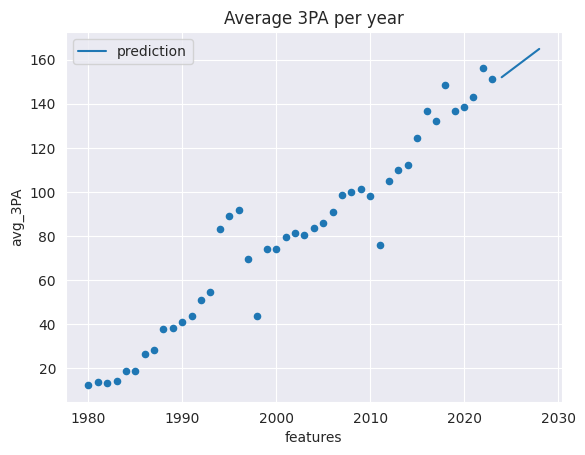

In [307]:
sns.set_style("darkgrid")

fig, ax = plt.subplots()
ax.set_xlabel("Year")
ax.set_ylabel("Average 3PA")
ax.set_title("Average 3PA per year")

pd_pred = pred.toPandas()
pd_pred["features"] = pd_pred["features"].apply(lambda x: x[0])
pd_pred.plot(x="features", y="avg_3PA", kind="scatter", ax=ax)

pd_new_pred = newt_5_years_predictions.toPandas()
pd_new_pred["features"] = pd_new_pred["features"].apply(lambda x: x[0])
pd_new_pred.plot(x="features", y="prediction", kind="line", ax=ax)

## All data

In [326]:
df = spark.read.csv('NBA_players_Totals.csv', header=True, inferSchema=True)
df = df.withColumn("Year", df["Season"].substr(0, 4).cast("Int"))

vector_assembler = VectorAssembler(inputCols=["Year"], outputCol="features")
data = vector_assembler.transform(df).select("features", "FG3A")
lr = LinearRegression(featuresCol = 'features', labelCol = 'FG3A')
lr_model = lr.fit(data)
pred = lr_model.transform(data)
spark.createDataFrame(pred.tail(10)).show()
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='FG3A')
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")
print(f"R2: {evaluator.setMetricName('r2').evaluate(pred)}")
newt_5_years_predictions = lr_model.transform(next_5_years_features)
newt_5_years_predictions.show()

24/06/20 23:04:40 WARN Instrumentation: [61b10b2e] regParam is zero, which might cause numerical instability and overfitting.


+--------+----+------------------+
|features|FG3A|        prediction|
+--------+----+------------------+
|[2023.0]|   3|148.84811795357018|
|[2023.0]|   1|148.84811795357018|
|[2023.0]|   0|148.84811795357018|
|[2023.0]|   0|148.84811795357018|
|[2023.0]|   0|148.84811795357018|
|[2023.0]|   0|148.84811795357018|
|[2023.0]|   2|148.84811795357018|
|[2023.0]|   0|148.84811795357018|
|[2023.0]|   0|148.84811795357018|
|[2023.0]|   6|148.84811795357018|
+--------+----+------------------+

Coefficients: [3.2052204072184507]
Intercept: -6335.312765849356
R2: 0.10401484636955782
+--------+------------------+
|features|        prediction|
+--------+------------------+
|[2024.0]|152.05333836078808|
|[2025.0]|155.25855876800688|
|[2026.0]|158.46377917522568|
|[2027.0]|161.66899958244358|
|[2028.0]|164.87421998966238|
+--------+------------------+



<Axes: title={'center': 'Average 3PA per year'}, xlabel='Year', ylabel='Average 3PA'>

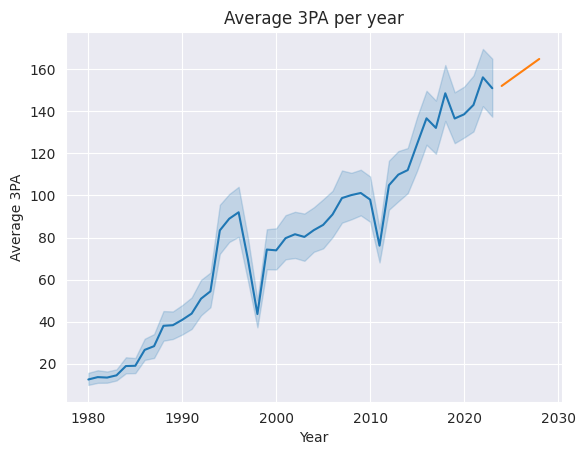

In [329]:
fig, ax = plt.subplots()
ax.set_xlabel("Year")
ax.set_ylabel("Average 3PA")
ax.set_title("Average 3PA per year")

pd_pred = pred.toPandas()
pd_pred["features"] = pd_pred["features"].apply(lambda x: x[0])
sns.lineplot(data=pd_pred, x="features", y="FG3A", ax=ax)

pd_new_pred = newt_5_years_predictions.toPandas()
pd_new_pred["features"] = pd_new_pred["features"].apply(lambda x: x[0])
sns.lineplot(data=pd_new_pred, x="features", y="prediction", ax=ax)

## All data

In [437]:
all_stages = [StringIndexer(inputCol=c, outputCol='idx_' + c) for c in ['TEAM']] + \
             [OneHotEncoder(inputCol='idx_' + c, outputCol='ohe_' + c) for c in ['TEAM']]

df_new = Pipeline(stages=all_stages).fit(df).transform(df)
select_df = df_new.select([col for col in df_new.columns[7:] if col not in ["PLAYER", "TEAM_ID", "PLAYER_ID", "TEAM"]])
select_df.show(5)
select_df = select_df[[col for col in select_df.columns if col != "FG3A"] + ["FG3A"]]
ad_df = select_df.rdd.map(lambda x: [Vectors.dense(x[:25]), x[-1]]).toDF(['features', 'label'])
ad_df.show()

+----+---+----+---+----+------+----+----+-------+---+---+------+----+----+----+---+---+---+---+---+----+----+-------+-------+----+--------+---------------+
|RANK| GP| MIN|FGM| FGA|FG_PCT|FG3M|FG3A|FG3_PCT|FTM|FTA|FT_PCT|OREB|DREB| REB|AST|STL|BLK|TOV| PF| PTS| EFF|AST_TOV|STL_TOV|Year|idx_TEAM|       ohe_TEAM|
+----+---+----+---+----+------+----+----+-------+---+---+------+----+----+----+---+---+---+---+---+----+----+-------+-------+----+--------+---------------+
|   1| 80|3417|909|1627| 0.559|   2|   7|  0.286|632|784| 0.806| 192| 317| 509|322|109| 18|282|245|2452|2258|   1.14|   0.39|1980|    34.0|(41,[34],[1.0])|
|   2| 80|3245|806|1545| 0.522|   1|   3|  0.333|609|804| 0.757| 474| 706|1180|141| 83|150|308|223|2222|2534|   0.46|   0.27|1980|     5.0| (41,[5],[1.0])|
|   3| 82|2765|850|1729| 0.492|   9|  35|  0.257|512|620| 0.826| 126| 293| 419|260| 94| 56|251|212|2221|1812|   1.04|   0.38|1980|    32.0|(41,[32],[1.0])|
|   4| 80|2976|836|1457| 0.574|   0|   1|    0.0|423|552| 0.766|

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,80.0,3417.0,...|    7|
|[2.0,80.0,3245.0,...|    3|
|[3.0,82.0,2765.0,...|   35|
|[4.0,80.0,2976.0,...|    1|
|[5.0,82.0,2874.0,...|   18|
|[6.0,82.0,3194.0,...|    9|
|[7.0,77.0,2620.0,...|   39|
|[8.0,81.0,3093.0,...|    5|
|[9.0,81.0,3028.0,...|   13|
|[10.0,81.0,2914.0...|    6|
|[11.0,80.0,2641.0...|   12|
|[12.0,71.0,2593.0...|   35|
|[13.0,82.0,3239.0...|   74|
|[14.0,79.0,2911.0...|   30|
|[15.0,81.0,2867.0...|   52|
|[16.0,82.0,2925.0...|    1|
|[17.0,82.0,1976.0...|  141|
|[18.0,65.0,2370.0...|   31|
|[19.0,79.0,2742.0...|   68|
|[20.0,82.0,2298.0...|    1|
+--------------------+-----+
only showing top 20 rows



In [446]:
lr = LinearRegression(featuresCol = 'features', labelCol = 'label')
train_data, test_data = ad_df.randomSplit([0.8, 0.2])
lr_model = lr.fit(train_data)
pred = lr_model.transform(train_data)
pred.show()

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")
print(f"R2: {evaluator.setMetricName('r2').evaluate(pred)}")

24/06/21 00:13:10 WARN Instrumentation: [14b045a4] regParam is zero, which might cause numerical instability and overfitting.
24/06/21 00:13:13 WARN Instrumentation: [14b045a4] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


+--------------------+-----+-------------------+
|            features|label|         prediction|
+--------------------+-----+-------------------+
|[1.0,66.0,2546.0,...|  344| 350.75165602451057|
|[1.0,68.0,2483.0,...|  843|   788.816246303679|
|[1.0,70.0,2624.0,...|  744|  744.0816586701958|
|[1.0,74.0,2732.0,...|  686|  632.1141556794796|
|[1.0,75.0,3173.0,...|  338|  330.1189732517478|
|[1.0,76.0,2652.0,...|  610|  617.1363835564594|
|[1.0,77.0,3140.0,...|  398|  377.4636916240145|
|[1.0,78.0,2867.0,...| 1028|   994.218912929601|
|[1.0,78.0,3038.0,...|  414| 391.83267072879585|
|[1.0,78.0,3067.0,...|  230| 229.31740543794047|
|[1.0,79.0,2817.0,...|   36|  33.14746950607673|
|[1.0,79.0,2923.0,...|    5| -1.657479203809089|
|[1.0,79.0,2984.0,...|    4|-17.071269545129326|
|[1.0,79.0,3048.0,...|  278|   259.040388829982|
|[1.0,80.0,3102.0,...|  100|  83.37823287646177|
|[1.0,80.0,3241.0,...|   29|   49.8227417294504|
|[1.0,80.0,3277.0,...|  518| 500.09434277580226|
|[1.0,80.0,3417.0,..

R2: 0.9891922814103375


In [447]:
test_pred = lr_model.transform(test_data)
test_pred.show()
print(f"R2: {evaluator.setMetricName('r2').evaluate(test_pred)}")

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[1.0,49.0,1705.0,...|    1| 5.685399949986277|
|[1.0,63.0,2152.0,...|  801| 854.8431961506394|
|[1.0,79.0,3163.0,...|    1| 3.120947919134096|
|[1.0,80.0,3215.0,...|  473| 485.1402735130389|
|[1.0,82.0,3034.0,...|   93| 76.99675798009196|
|[1.0,82.0,3197.0,...|  245| 236.7384101158052|
|[1.0,82.0,3401.0,...|  324|360.97912874908866|
|[2.0,48.0,1990.0,...|  199| 191.4177837022321|
|[2.0,75.0,2954.0,...|  448| 472.6855885755342|
|[2.0,78.0,2948.0,...|  129|127.84824229510855|
|[2.0,78.0,3013.0,...|  407| 368.9709961390706|
|[2.0,78.0,3049.0,...|   70| 66.32592433414982|
|[2.0,79.0,3361.0,...|  379|358.22670277319935|
|[2.0,81.0,3054.0,...|  384|364.84180670443175|
|[2.0,81.0,3265.0,...|  554| 602.8299373039081|
|[2.0,82.0,2909.0,...|   51|19.461319509777127|
|[2.0,82.0,2998.0,...|   13| 5.881366424906332|
|[3.0,67.0,2675.0,...|  513|485.98386326

R2: 0.9890387382309028
